In [1]:
import sys

!{sys.executable} -m pip install torch
!{sys.executable} -m pip install qiskit
!{sys.executable} -m pip install pylatexenc
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install itertools

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
You should consider upgrading via the '/usr

In [2]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

In [3]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [4]:
from tqdm import tqdm

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
np.random.seed = 42

NUM_QUBITS = 2
NUM_SHOTS = 5000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [7]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools

def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['00', '01', '10', '11']


# Contruct QuantumCircuit QFT Class

In [8]:
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.thetas = { k: Parameter('Theta'+str(k)) for k in range(self.n_qubits) }
        
        all_qubits = [i for i in range(n_qubits)]
        
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
            
        self.circuit.measure_all()
        
        self.backend = backend
        self.shots = shots
        
    def N_qubits_expectation_Z(self, counts, shots, n_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) / shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        
        job_sim = execute(self.circuit, 
                          self.backend, 
                          shots = self.shots, 
                          parameter_binds = [{ self.thetas[k]: params[k].item() for k in range(self.n_qubits) }])
        
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        
        return self.N_qubits_expectation_Z(counts, self.shots, self.n_qubits)

Expected value for rotation [pi/4]: [0.0198 0.1216 0.116  0.7426]


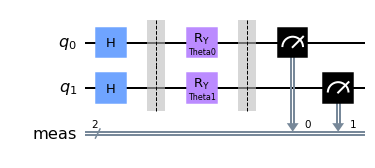

In [9]:
circuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print(f'Expected value for rotation [pi/4]: {circuit.run(torch.Tensor([np.pi/4] * len(QC_OUTPUTS)))}')
circuit.circuit.draw(output='mpl')

In [10]:
class TorchCircuit(Function):
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QuantumCircuit'):
            ctx.QuantumCircuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
        
        exp_value = ctx.QuantumCircuit.run(i)
        
        result = torch.Tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor,i = ctx.saved_tensors
        
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            expectation_right = ctx.QuantumCircuit.run(shift_right)
            expectation_left = ctx.QuantumCircuit.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradient = gradient / torch.norm(gradient)
            
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
        
        return (result.float() * grad_output.float()).T

In [11]:
x = torch.tensor([np.pi/4] * NUM_QUBITS, requires_grad=True)
qc = TorchCircuit.apply

y1 = qc(x)
print(f'y1 after quantum layer: {y1}')
y1 = nn.Linear(2**NUM_QUBITS, 1)(y1.float())

y1.backward()
print(f'x.grad = {x.grad}')

y1 after quantum layer: tensor([[0.0226, 0.1224, 0.1282, 0.7268]], grad_fn=<TorchCircuitBackward>)
x.grad = tensor([0.0132, 0.0438])


100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


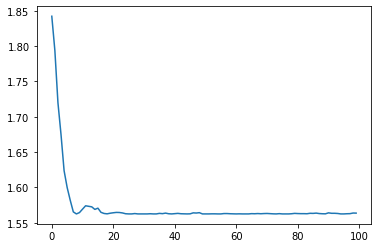

In [12]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    
    val = sum([(i + 1) * expval[i] for i in range(2**NUM_QUBITS)]) / 2**NUM_QUBITS
    
    return torch.abs(target - val) ** 2, expval


x = torch.tensor([-np.pi/4] * NUM_QUBITS, requires_grad=True)
opt = optim.Adam([x], lr = 0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)
    
plt.plot(loss_list)

In [13]:
from torch.functional import F

In [14]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

In [15]:
TRAIN_DATA_PATH = "./data/hurricane_damage_dataset/test/"
TEST_DATA_PATH = "./data/hurricane_damage_dataset/validation_another/"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])


train_samples = 900
test_samples = 100


train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
# train_idx = np.append(np.where(train_data.targets == 0)[0][:train_samples], 
#                 np.where(train_data.targets == 1)[0][:train_samples])

X_train = torch.utils.data.Subset(train_data, np.random.choice(len(train_data), train_samples, replace=False))


# train_data.data = train_data.data[train_idx]
# train_data.targets = train_data.targets[train_idx]

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
# test_idx = np.append(np.where(test_data.targets == 0)[0][:test_samples], 
#                 np.where(test_data.targets == 1)[0][:test_samples])

# test_data.data = test_data.data[test_idx]
# test_data.targets = test_data.targets[test_idx]

X_test = torch.utils.data.Subset(test_data, np.random.choice(len(test_data), test_samples, replace=False))


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

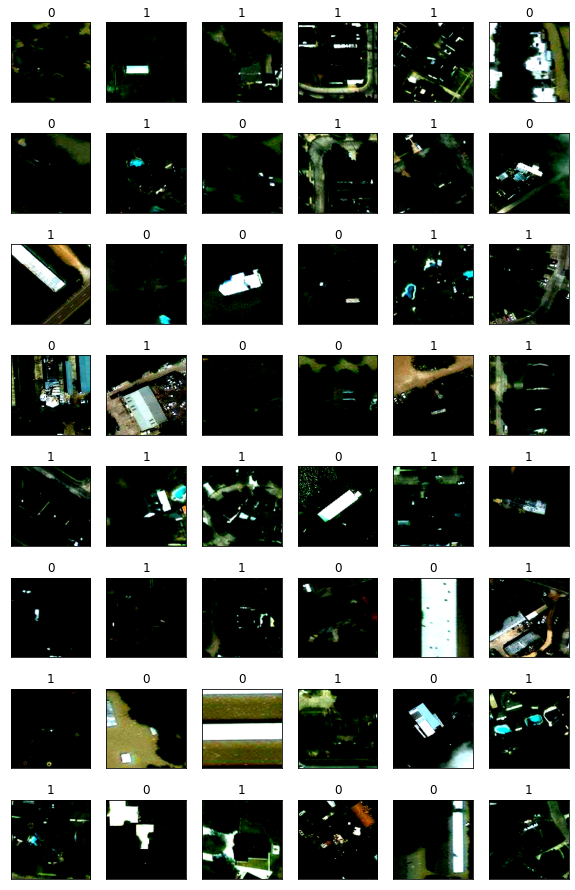

In [16]:
n_sample_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_sample_shape[0], ncols=n_sample_shape[1], figsize=(10, 2*n_sample_shape[0]))

# classes_map = {
#     0: 'T-shirt/top',
#     1: 'Trouser',
#     2: 'Pullover',
#     3: 'Dress',
#     4: 'Coat',
#     5: 'Sandal',
#     6: 'Shirt',
#     7: 'Sneaker',
#     8: 'Bag',
#     9: 'Ankle boot'
# }

# network.eval()
# with torch.no_grad():
for batch_idx, (data, target) in enumerate(test_loader):
    if count == n_sample_shape[0]*n_sample_shape[1]:
        break

#     prediction = network.predict(data).item()

    prepared_img = data[0].numpy().squeeze()

    axes[count // n_sample_shape[1]][count % n_sample_shape[1]].imshow(data[0].permute(1, 2, 0))

    axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_xticks([])
    axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_yticks([])
    axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_title(target.item())

    count += 1

In [17]:

# n_samples = 1000

# X_train = datasets.FashionMNIST(root='./data', 
#                                 train=True,
#                                 download=True,
#                                 transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
#                 np.where(X_train.targets == 1)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_train.targets == 2)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_train.targets == 3)[0][:n_samples])

# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

In [18]:
# train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

In [19]:
# n_samples = 50

# X_test = datasets.FashionMNIST(root='./data', 
#                                train=False,
#                                download=True,
#                                transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
#                 np.where(X_test.targets == 1)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_test.targets == 2)[0][:n_samples])
# # idx = np.append(idx, 
# #                 np.where(X_test.targets == 3)[0][:n_samples])

# X_test.data = X_test.data[idx]
# X_test.targets = X_test.targets[idx]

In [20]:
# test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

# Building network

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        DROPOUT = 0.5
    
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1)
#         self.convnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=6, stride=1, padding=1)
#         self.convnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(64, 64, kernel_size = 6, stride = 1, padding = 1)
#         self.convnorm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.AvgPool2d((2, 2))

        self.dropout = nn.Dropout(DROPOUT)
        self.linear1 = nn.Linear(64 * 13 * 13, 16)
#         self.linear1_bn = nn.BatchNorm1d(16)
        self.linear2 = nn.Linear(16, 2)
#         self.linear2_bn = nn.BatchNorm1d(2)
        self.sigmoid = torch.sigmoid
        self.relu = torch.relu

        
        
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        # print(x.shape)
        x = self.dropout(self.relu(self.linear1(x.view(-1, 64 * 13 * 13))))
        x = self.dropout(self.relu(self.linear2(x)))
        x = self.sigmoid(x)
        return x
    
    
    def predict(self, x):
        
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        
        return torch.tensor(ans)
    
# network = Net()
# optimizer = optim.Adam(network.parameters(), lr=0.001)

LR = 0.01

network = Net()
optimizer = torch.optim.SGD(network.parameters(), lr = LR, momentum = 0.9)



In [22]:
def train_network(network, optimizer, train_loader, val_loader):
    epochs = 50
    criterion = nn.CrossEntropyLoss()

    loaders = {
        'train': train_loader,
        'val': val_loader
    }
    
    loss_results = {
        'train': [],
        'val': []
    }

    acc_results = {
        'train': [],
        'val': []
    }

    loaders = {
        'train': train_loader,
        'val': test_loader
    }

    for epoch in range(epochs):
        total_loss = {
            'train': [],
            'val': []
        }

        total_acc = {
            'train': [],
            'val': []
        }


        for phase in ['train', 'val']:
            if phase == 'train':
                network.train(True)
            else:
                network.train(False)

            correct = 0
            number = 0

            for batch_idx, (data, target) in enumerate(loaders[phase]):
                optimizer.zero_grad()
                output = network(data)

                loss = criterion(output, target)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                total_loss[phase].append(loss.item())

                _, predicted = torch.max(output.data, 1)
                number += target.size(0)
                correct += (predicted == target).sum().item()

            loss_results[phase].append(sum(total_loss[phase]) / len(total_loss[phase]))
            acc_results[phase].append(100 * correct / number)

        progress = 100.0 * (epoch + 1) / epochs

        print(f'Training [{int(progress)}%]\tTraining loss {loss_results["train"][-1]}\tValidation loss {loss_results["val"][-1]}\tTraining acc {acc_results["train"][-1]}\tValidation acc {acc_results["val"][-1]}')
        
    return {
        'train_loss': loss_results["train"][-1],
        'val_loss': loss_results["val"][-1],
        'train_acc': acc_results["train"][-1],
        'val_acc': acc_results["val"][-1]
    }


In [25]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

dataset = ConcatDataset([X_train, X_test])

k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)

results = {}

print('--------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
  
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=1, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=1, sampler=test_subsampler)

    network = Net()
    network.apply(reset_weights)
    
#     optimizer = optim.Adam(network.parameters(), lr=0.000005)
    optimizer = optim.Adam(network.parameters(), lr=0.00001)
#     optimizer = torch.optim.SGD(network.parameters(), lr = 0.00001, momentum = 0)
    
    result = train_network(network, optimizer, trainloader, testloader)
    
    results[fold] = result
    
    print(result)
    print('--------------------------------')

print('--------------------------------')
print('FINAL RESULTS')
print('--------------------------------')
print(results)
    

--------------------------------
FOLD 0
--------------------------------
Training [2%]	Training loss 0.6935681105405093	Validation loss 0.6906436836719513	Training acc 51.0	Validation acc 54.0
Training [4%]	Training loss 0.6926044729351998	Validation loss 0.6903615754842758	Training acc 52.25	Validation acc 57.0
Training [6%]	Training loss 0.6916784957051277	Validation loss 0.6872911101579666	Training acc 50.625	Validation acc 58.0
Training [8%]	Training loss 0.6849750422686338	Validation loss 0.6832661128044129	Training acc 54.125	Validation acc 59.0
Training [10%]	Training loss 0.6765895583108068	Validation loss 0.6687048953771592	Training acc 59.25	Validation acc 70.0
Training [12%]	Training loss 0.6707358491048216	Validation loss 0.6491213035583496	Training acc 58.75	Validation acc 77.0
Training [14%]	Training loss 0.6632912315428257	Validation loss 0.6559732401371002	Training acc 60.75	Validation acc 63.0
Training [16%]	Training loss 0.6633954977244139	Validation loss 0.6465944939

Training [34%]	Training loss 0.6480920945852995	Validation loss 0.607022000849247	Training acc 64.375	Validation acc 86.0
Training [36%]	Training loss 0.6468768664449454	Validation loss 0.6058710592985154	Training acc 65.25	Validation acc 84.0
Training [38%]	Training loss 0.6487813410907983	Validation loss 0.593321418762207	Training acc 63.75	Validation acc 88.0
Training [40%]	Training loss 0.6503807247802615	Validation loss 0.6022593042254448	Training acc 61.625	Validation acc 83.0
Training [42%]	Training loss 0.6452196052297949	Validation loss 0.6018348300457	Training acc 64.75	Validation acc 82.0
Training [44%]	Training loss 0.6463473703339696	Validation loss 0.6111418667435646	Training acc 62.125	Validation acc 77.0
Training [46%]	Training loss 0.6512183718010783	Validation loss 0.5817373499274254	Training acc 62.5	Validation acc 90.0
Training [48%]	Training loss 0.6414279901236296	Validation loss 0.5800138953328132	Training acc 65.875	Validation acc 86.0
Training [50%]	Training lo

Training [66%]	Training loss 0.6272822881862521	Validation loss 0.5573967632651329	Training acc 64.625	Validation acc 87.0
Training [68%]	Training loss 0.6221433404833079	Validation loss 0.5568144756555558	Training acc 67.875	Validation acc 88.0
Training [70%]	Training loss 0.6198178672790527	Validation loss 0.5565390387177467	Training acc 66.375	Validation acc 87.0
Training [72%]	Training loss 0.621703337430954	Validation loss 0.5550381156802178	Training acc 66.75	Validation acc 87.0
Training [74%]	Training loss 0.6152607076987624	Validation loss 0.5590288910269737	Training acc 66.5	Validation acc 85.0
Training [76%]	Training loss 0.6287542406469584	Validation loss 0.554979772567749	Training acc 65.0	Validation acc 87.0
Training [78%]	Training loss 0.6221511570736766	Validation loss 0.5625109708309174	Training acc 68.25	Validation acc 82.0
Training [80%]	Training loss 0.6228291628882289	Validation loss 0.5570679426193237	Training acc 66.125	Validation acc 86.0
Training [82%]	Training 

Training [98%]	Training loss 0.6931471824645996	Validation loss 0.6931471824645996	Training acc 48.625	Validation acc 46.0
Training [100%]	Training loss 0.6931471824645996	Validation loss 0.6931471824645996	Training acc 48.625	Validation acc 46.0
{'train_loss': 0.6931471824645996, 'val_loss': 0.6931471824645996, 'train_acc': 48.625, 'val_acc': 46.0}
--------------------------------
FOLD 4
--------------------------------
Training [2%]	Training loss 0.6931720301508904	Validation loss 0.6910773622989654	Training acc 50.5	Validation acc 54.0
Training [4%]	Training loss 0.6915339881926775	Validation loss 0.6896573930978775	Training acc 51.375	Validation acc 54.0
Training [6%]	Training loss 0.6896769507229328	Validation loss 0.6828641504049301	Training acc 48.625	Validation acc 54.0
Training [8%]	Training loss 0.6892344592884183	Validation loss 0.6809740769863128	Training acc 47.625	Validation acc 54.0
Training [10%]	Training loss 0.6851715417951345	Validation loss 0.6801110416650772	Traini

In [ ]:
# epochs = 25
# loss_func = nn.CrossEntropyLoss()

# loss_results = {
#     'train': [],
#     'val': []
# }

# acc_results = {
#     'train': [],
#     'val': []
# }

# loaders = {
#     'train': train_loader,
#     'val': test_loader
# }

# for epoch in range(epochs):
#     total_loss = {
#         'train': [],
#         'val': []
#     }
    
#     total_acc = {
#         'train': [],
#         'val': []
#     }
    
    
#     for phase in ['train', 'val']:
#         if phase == 'train':
#             network.train(True)
#         else:
#             network.train(False)
        
#         correct = 0
#         number = 0
        
#         for batch_idx, (data, target) in enumerate(loaders[phase]):
#             optimizer.zero_grad()
#             output = network(data)
            
#             loss = loss_func(output, target)
            
#             if phase == 'train':
#                 loss.backward()
#                 optimizer.step()

#             total_loss[phase].append(loss.item())

#             _, predicted = torch.max(output.data, 1)
#             number += target.size(0)
#             correct += (predicted == target).sum().item()

#         loss_results[phase].append(sum(total_loss[phase]) / len(total_loss[phase]))
#         acc_results[phase].append(100 * correct / number)

#     progress = 100.0 * (epoch + 1) / epochs
    
#     print(f'Training [{int(progress)}%]\tTraining loss {loss_results["train"][-1]}\tValidation loss {loss_results["val"][-1]}\tTraining acc {acc_results["train"][-1]}\tValidation acc {acc_results["val"][-1]}')
    

In [ ]:
# plt.plot(loss_results["train"])
# plt.title(f'Hybrid NN training convergence for {NUM_QUBITS}-qubits')
# plt.xlabel('epoch')
# plt.ylabel('loss')

In [ ]:
# plt.plot(loss_results["val"])
# plt.title(f'Hybrid NN training convergence for {NUM_QUBITS}-qubits')
# plt.xlabel('epoch')
# plt.ylabel('loss')

# Test accuracy

In [ ]:
# accuracy = 0
# number = 0
# for batch_idx, (data, target) in enumerate(test_loader):
#     number += 1
#     output = network.predict(data).item()
#     accuracy += (output == target[0].item())*1

In [ ]:
# print(f'Performance on test data: {accuracy}/{number} = {accuracy/number*100}%')

In [ ]:
# n_sample_shape = (8, 6)
# count = 0
# fig, axes = plt.subplots(nrows=n_sample_shape[0], ncols=n_sample_shape[1], figsize=(10, 2*n_sample_shape[0]))

# classes_map = {
#     0: 'T-shirt/top',
#     1: 'Trouser',
#     2: 'Pullover',
#     3: 'Dress',
#     4: 'Coat',
#     5: 'Sandal',
#     6: 'Shirt',
#     7: 'Sneaker',
#     8: 'Bag',
#     9: 'Ankle boot'
# }

# network.eval()
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(test_loader):
#         if count == n_sample_shape[0]*n_sample_shape[1]:
#             break
        
#         prediction = network.predict(data).item()
        
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')
        
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_xticks([])
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_yticks([])
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_title(classes_map[prediction])
        
#         count += 1